Real estate pricing prediction app

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

In [3]:
df = pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.shape

(13320, 9)

In [5]:
#print a count of each area type
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [6]:
#drop columns you don't need or think will have a major effect on prices 
dfdropcol = df.drop(['area_type','society','balcony','availability'], axis='columns')
dfdropcol.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [7]:
#data cleaning
#handling NA values 
#use isnull fn to check no of rows that are null. 

dfdropcol.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
# use dropna to drop. either drop the rows or fill those null with average of the col. 
# In this case, total null rows is small compared to total of 13k rows so ok to drop rows

dfdropcoldroprow = dfdropcol.dropna()
dfdropcoldroprow.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
dfdropcoldroprow.shape

(13246, 5)

Feature Engineering

In [10]:
#some rows are not labeled properly e.g. the units  for some rows in the size col say BHK while some say bedroom
#BHK and bedroom should mean the same thing in this context

dfdropcoldroprow['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [11]:
# to solve this issue, a new column is needed called BHK
# a function will be required to clean up the labels. you can either apply a lambda fn or native python fn
#create a new col based on the size col and tokenize the first character in the size col using lambda fn
#apply a transformation on each value of the size col 
# split each value using space and then take the first token and convert to an integer. 
#Save to a new col called bhk

dfdropcoldroprow['bhk'] = dfdropcoldroprow['size'].apply(lambda x: int(x.split(' ')[0]))

/Users/Peluoluwa/opt/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
dfdropcoldroprow.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [13]:
dfdropcoldroprow['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [14]:
# view what kind of bedroom has more than 20 rooms
# these entries/bedrooms look like errors

dfdropcoldroprow[dfdropcoldroprow.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [15]:
#check other columns for anomalies

dfdropcoldroprow.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [16]:
#some of the total sqft entries are in range so convert the range to an average
#first define a fn that checks if number is float

def is_float(x):
    try:
        float(x)
    except:
        return False 
    return True

In [17]:
# apply the fn to check if values in total sq ft col is float 
# add ~ to invert i.e. see everything that is not float

dfdropcoldroprow[~dfdropcoldroprow['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [18]:
#some of the rows have different units others just have range so still needs clean up
# if you have time, you can convert the units, need to write fn for conversion of units
# for rows without units, write simple fn to split the tokens to two and return avg 
# otherwise if its a normal number, convert and return float

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    elif len(tokens)==3:
        return (float(tokens[0])+float(tokens[2]))/2
    try:
        return float(x)
    except:
        return None
 
#convert_sqft_to_num('1015 - 1540')


In [19]:
#need to copy the df, convert and save in a new df

dfconv = dfdropcoldroprow.copy()
dfconv['total_sqft'] = dfconv['total_sqft'].apply(convert_sqft_to_num)
dfconv.head(10)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
5,Whitefield,2 BHK,1170.0,2.0,38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,370.00,6


In [20]:
# access row index 30 the location where the first range  is to check if the average works 2475 inst of 2100-2850

dfconv.loc[30]

location      Yelahanka
size              4 BHK
total_sqft         2475
bath                  4
price               186
bhk                   4
Name: 30, dtype: object

More feature engineering
price /sf is important in real estate so check. this also helps detect outliers

In [21]:
dfnew = dfconv.copy()
dfnew['price_per_sqft'] = dfnew['price']*100000/dfnew['total_sqft']
dfnew.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [22]:
# usually to handle text data, convert to columns i.e. one hot encoding
# but in this case 1300 cols will be too many cols - dimensionality curse - high dimensions


len(dfnew['location'].unique())

1304

In [23]:
# figure out how many data points are available per location
# strip extra spaces from the location to ensure the data is clean
# group df by using location and then extract the location col and then count and then sort


dfnew.location = dfnew.location.apply(lambda x: x.strip())
location_stats = dfnew.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
Thanisandra          236
                    ... 
LIC Colony             1
Kuvempu Layout         1
Kumbhena Agrahara      1
Kudlu Village,         1
1 Annasandrapalya      1
Name: location, Length: 1293, dtype: int64

In [24]:
# determine threshold to group locations with less than amount as other
len(location_stats[location_stats<=10])

1052

In [25]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
BTM 1st Stage          10
Basapura               10
Sector 1 HSR Layout    10
Naganathapura          10
Kalkere                10
                       ..
LIC Colony              1
Kuvempu Layout          1
Kumbhena Agrahara       1
Kudlu Village,          1
1 Annasandrapalya       1
Name: location, Length: 1052, dtype: int64

In [26]:
len(dfnew.location.unique())

1293

In [27]:
dfnew.location = dfnew.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(dfnew.location.unique())

242

In [28]:
dfnew

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


Outlier detection


In [29]:
# outliers are extreme variations in dataset. They should be removed since they will cause issues/ skew the data. 
# To assess/determine what to remove, use domain knowledge. 
# e.g. sq footage cannot be less than ~ 500 sq ft. 
# total no of bedrooms too high, or sq footage too low. 
# e.g. if sq ft < 300, show the value so you can determine if it makes sense

dfnew[dfnew.total_sqft/dfnew.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [30]:
dfnew.shape

(13246, 7)

In [31]:
# after outlier removed, 12k out 13k rows left

dfoutlier = dfnew[~(dfnew.total_sqft/dfnew.bhk<300)]
dfoutlier.shape

(12502, 7)

In [32]:
# check $/sf. if too high or too low. view stats using .describe()

dfoutlier.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [33]:
# filter out anything with price per sqft beyond 1 SD. Rows filtered and left is 10k

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out

dfoutfilter = remove_pps_outliers(dfoutlier)
dfoutfilter.shape

(10241, 7)

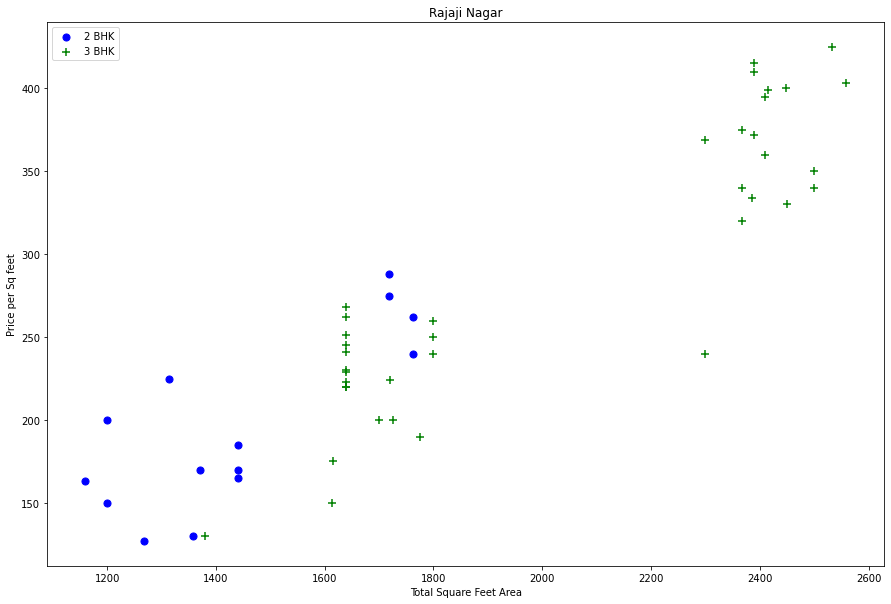

In [34]:
# create fn to plot to visualize data

def plot_scatter(df, location):
    bhk2 = df[(df.location ==location) & (df.bhk==2)]    #create dataframe where there is a 2 or 3 bd for specified location
    bhk3 = df[(df.location ==location) & (df.bhk==3)] 
    matplotlib.rcParams['figure.figsize'] =(15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color = 'blue', label = '2 BHK', s =50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker = '+', color = 'green', label = '3 BHK', s =50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price per Sq feet")
    plt.title(location)
    plt.legend()
    

plot_scatter(dfoutfilter, "Rajaji Nagar")

In [35]:
# try plotting "Hebbal" location too

In [43]:
# remove the outliers where price /sf of 2 bd is higher than that of 3 bd 
# create function to remove these outliers. 
# the fn filters all the values of the 3 bd whose price is less than mean of the 2 bed

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

dfoutnew = remove_bhk_outliers(dfoutfilter)     
dfoutnew.shape 

(7329, 7)

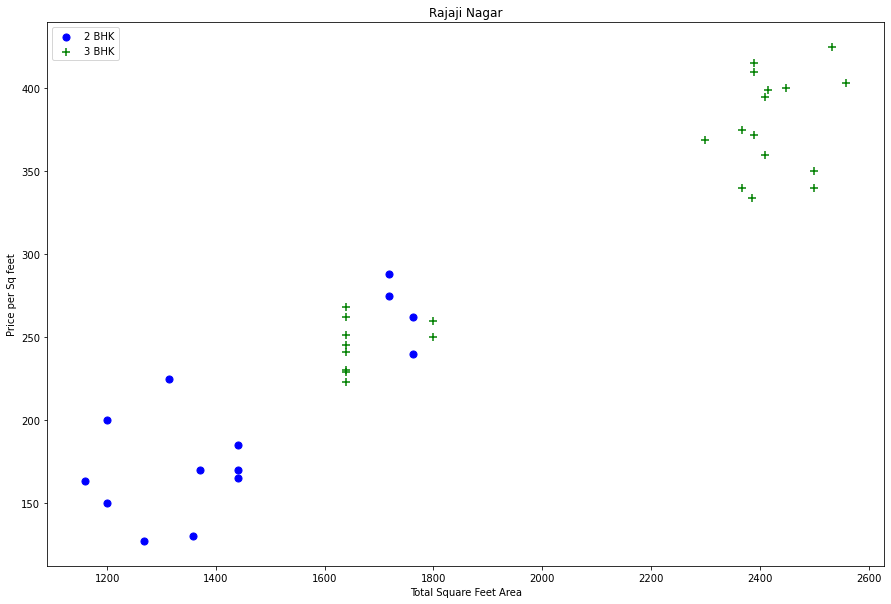

In [44]:
plot_scatter(dfoutnew, "Rajaji Nagar")

Text(0, 0.5, 'Count')

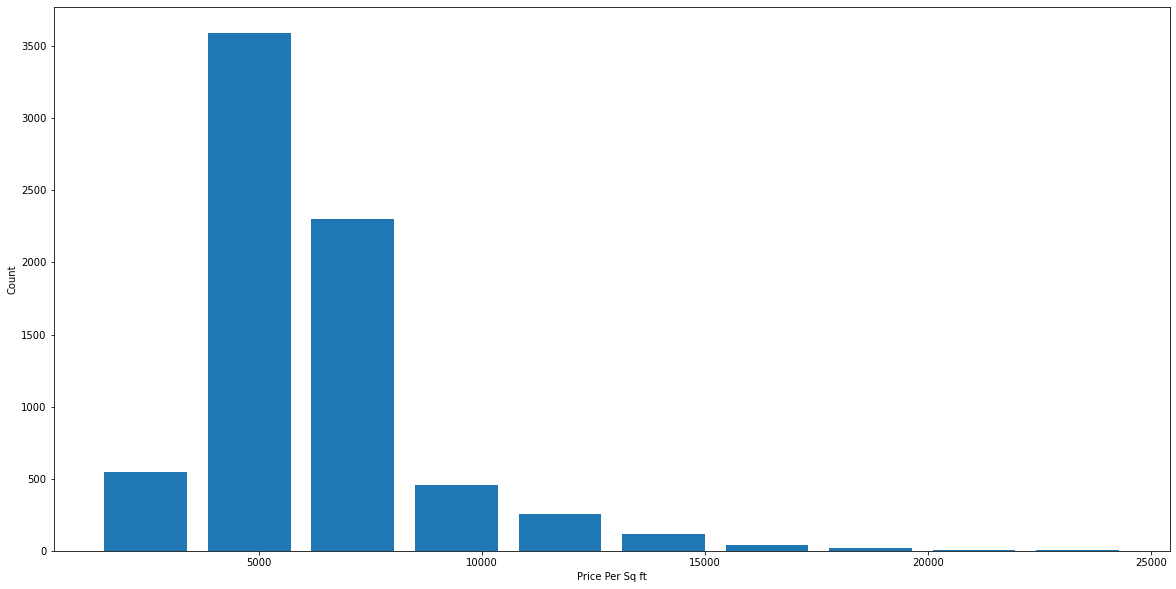

In [45]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(dfoutnew.price_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Sq ft")
plt.ylabel("Count")

In [46]:
dfoutnew.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [47]:
dfoutnew[dfoutnew.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


In [53]:
# remove rows where bathroom is greater than bedrooms+2

dfoutnew[dfoutnew.bath>dfoutnew.bhk+2]


,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [54]:
dfbathfilter = dfoutnew[dfoutnew.bath<dfoutnew.bhk+2]
dfbathfilter.shape

(7251, 7)

In [56]:
# drop price per sq ft and size - they were only used for outlier detection
dfdropout = dfbathfilter.drop(['size', 'price_per_sqft'], axis='columns')
dfdropout.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


One hot encoding / dummy variable


In [57]:
# Since the model cannot process strings, convert the string variables to numbers using dummy variables.
# for each location, it creates a new column and sets the value to 1 while others are 0

dummies = pd.get_dummies(dfdropout.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# join existing df to newly created dummies table
# you should have one less dummies column to avoid a dummy variable trap. drop last col 'other'

dfencode = pd.concat([dfdropout, dummies.drop('other', axis = 'columns')], axis = 'columns')
dfencode.head(5)

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# drop location column since it is now one hot encoded

dfencodedrop = dfencode.drop(['location'], axis = 'columns')

dfencodedrop.head()


,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# start model

X = dfencodedrop.drop('price', axis = 'columns')
y = dfencodedrop['price']
y.head()


0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [63]:
# split data into training and testing data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

In [74]:
#import linear regression model and train on data

from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.8452277697874314

In [65]:
# try couple other models and parameters and  aim for high score to arrive at optimal model
# use k cross fold validation to randomize sample selection

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #shuffle split randomizes the sample 

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [66]:
# try other regression algos - Lasso or decision trees in addition to lr
# gridsearchCV will go through the models and select not just the best model but will optimize the parameters too


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression':{
            'model': LinearRegression(),
            'params':{
                'normalize':[True, False]
            }
        },
        'lasso':{
            'model': Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random', 'cyclic']
            }
        },
        'decision_tree':{
            'model': DecisionTreeRegressor(),
            'params':{
                'criterion':['mse','friedman_mse'],
                'splitter':['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    for algo_name, config in algos.items():
        gridmodel = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gridmodel.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gridmodel.best_score_,
            'best_params': gridmodel.best_params_
        })
        
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.818354,{'normalize': False}
1,lasso,0.687429,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.728228,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [67]:
# try another algo like decision trees

# from sklearn.tree import DecisionTreeRegressor
# trees_model = DecisionTreeRegressor(criterion='friedman_mse', splitter='random')
# trees_model.fit(X_train, y_train)
# trees_model.score(X_test, y_test)

0.6840564889862458

In [75]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [76]:
#fn to make predictions based on location, sqft, bd/ba, rooms or bhk

def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]  # this returns the location index- locations are now columns
# np.where(X.columns=='Vittasandra')[0][0]
# # np.where(X.columns=='1st Block Jayanagar')[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index]=1        #set this column of the x index i.e. location to 1 so that the model can predict price
    
    return lr_model.predict([x])[0]
    


In [190]:
# x = np.zeros(len(X.columns))
# print(y)

In [77]:
predict_price('Indira Nagar',1000,4,3)

189.66332696484508

In [80]:
predict_price('1st Block Jayanagar',1000,3,2)

207.07100401243204

In [81]:
predict_price('Yelachenahalli',1000,2,2)

51.10754388980045

In [86]:
# write y column/output to excel 

# y.to_excel("outputy.xlsx")  

In [84]:
# export the model as pickle file for input into website

import pickle
with open('bangalore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_model,f)

In [85]:
# export the structure for making the prediction as json file

import json
columns = {
    'data_columns':[col.lower() for col in X.columns]
}

with open("columns.json","w") as f:
    f.write(json.dumps(columns))

once artifacts are exported, next will be creating Python Flask Server